In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from statsmodels.api import OLS, add_constant
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
data = pd.read_csv("df.csv")

In [3]:
data.head()

,Unnamed: 0,arrest_date,ofns_desc,law_cat_cd,age_group,perp_sex,perp_race,arrest_boro,arrest_precinct,jurisdiction_code,:@computed_region_f5dn_yrer,:@computed_region_92fq_4b7q,arrest_year,arrest_month,arrest_day,PRCP,SNOW,TMIN,TDELTA
0,0,2019-01-26,86,1,3,0,1,2,25,0.0,7.0,36.0,2019,1,26,0.0,0.0,24,11
1,1,2019-01-26,8,2,2,1,1,4,105,0.0,63.0,47.0,2019,1,26,0.0,0.0,24,11
2,2,2019-01-26,25,1,2,1,2,3,43,0.0,58.0,31.0,2019,1,26,0.0,0.0,24,11
3,3,2019-01-26,8,2,2,0,1,3,52,0.0,24.0,40.0,2019,1,26,0.0,0.0,24,11
4,4,2019-01-26,17,2,2,0,3,5,120,0.0,4.0,13.0,2019,1,26,0.0,0.0,24,11


In [4]:
data['arrest_date'] = pd.to_datetime(data['arrest_date'])
grouped_data = data.groupby('arrest_date').agg({
    'PRCP': 'first',  # Weather info (first since it doesn't vary within a date)
    'SNOW': 'first',
    'TMIN': 'first',
    'TDELTA': 'first',
    'arrest_year': 'first',
    'arrest_month': 'first',
    'arrest_day': 'first',
    'Unnamed: 0': 'count'  # Sum of crimes (using a consistent column for count)
}).reset_index()

# Rename columns for clarity
grouped_data.rename(columns={'Unnamed: 0': 'total_crimes'}, inplace=True)



In [5]:
grouped_data

,arrest_date,PRCP,SNOW,TMIN,TDELTA,arrest_year,arrest_month,arrest_day,total_crimes
0,2013-01-01,0.00,0.0,26,14,2013,1,1,676
1,2013-01-02,0.00,0.0,22,11,2013,1,2,880
2,2013-01-03,0.00,0.0,24,8,2013,1,3,1032
3,2013-01-04,0.00,0.0,30,7,2013,1,4,958
4,2013-01-05,0.00,0.0,32,10,2013,1,5,799
...,...,...,...,...,...,...,...,...,...
2551,2019-12-27,0.00,0.0,46,8,2019,12,27,349
2552,2019-12-28,0.00,0.0,43,8,2019,12,28,278
2553,2019-12-29,0.25,0.0,39,5,2019,12,29,226
2554,2019-12-30,0.74,0.0,37,4,2019,12,30,249


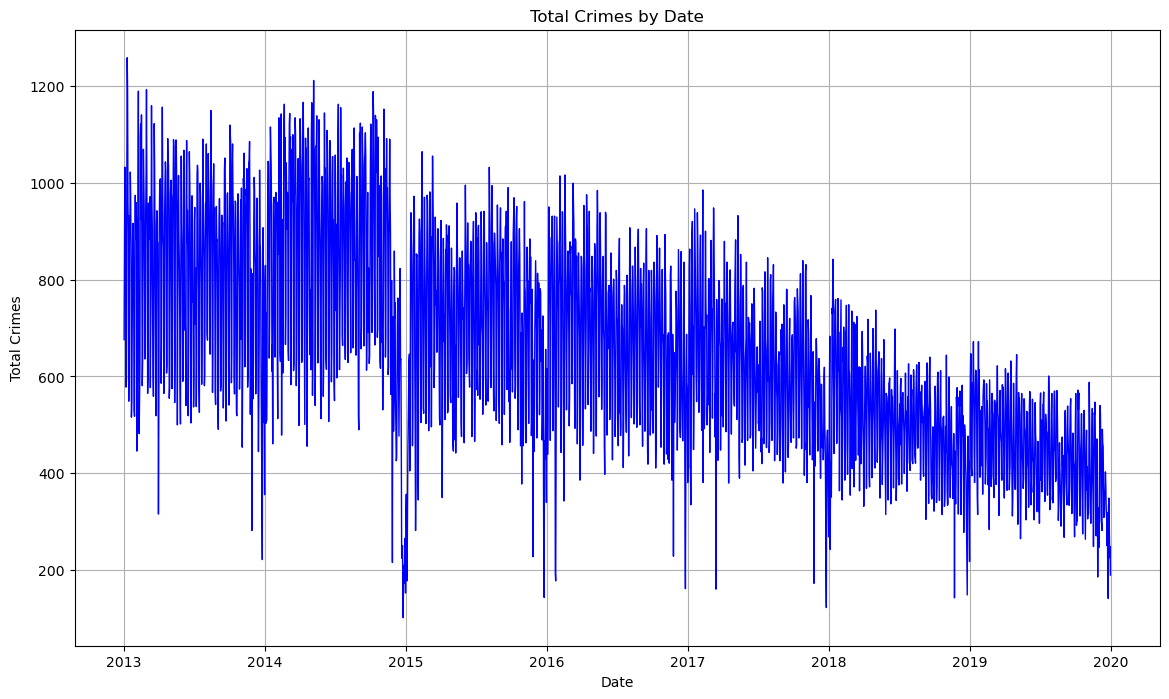

In [6]:
plt.figure(figsize=(14, 8))
plt.plot(grouped_data['arrest_date'], grouped_data['total_crimes'], color='blue', linewidth=1)
plt.title("Total Crimes by Date")
plt.xlabel("Date")
plt.ylabel("Total Crimes")
plt.grid(True)
plt.show()

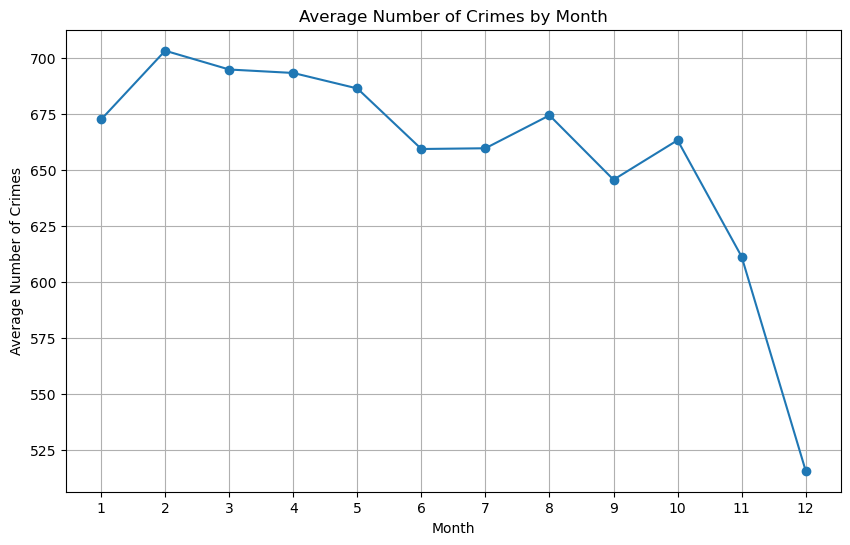

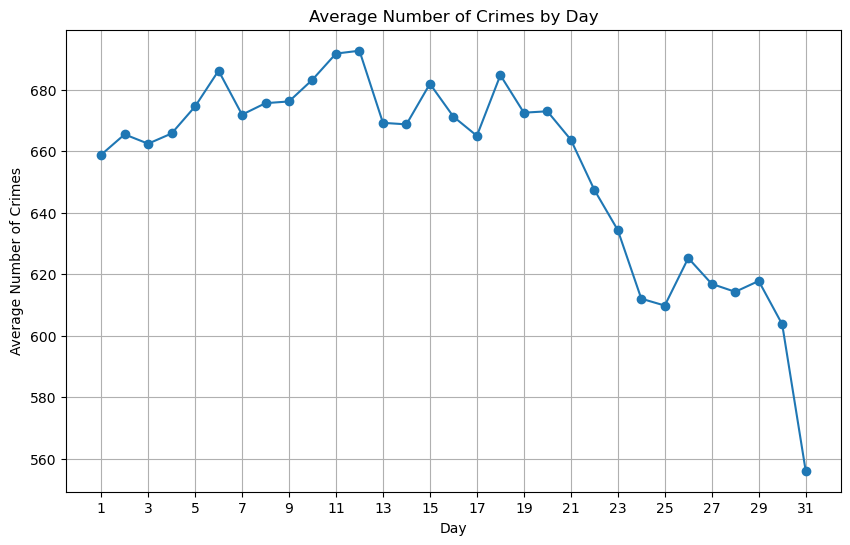

In [7]:
monthly_avg = grouped_data.groupby('arrest_month')['total_crimes'].mean()
daily_avg = grouped_data.groupby('arrest_day')['total_crimes'].mean()

# Plot average crimes by month
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title("Average Number of Crimes by Month")
plt.xlabel("Month")
plt.ylabel("Average Number of Crimes")
plt.xticks(range(1, 13))  # Ensure all months are displayed
plt.grid(True)
plt.show()

# Plot average crimes by day
plt.figure(figsize=(10, 6))
plt.plot(daily_avg.index, daily_avg.values, marker='o')
plt.title("Average Number of Crimes by Day")
plt.xlabel("Day")
plt.ylabel("Average Number of Crimes")
plt.xticks(range(1, 32, 2))  # Show days with an interval
plt.grid(True)
plt.show()

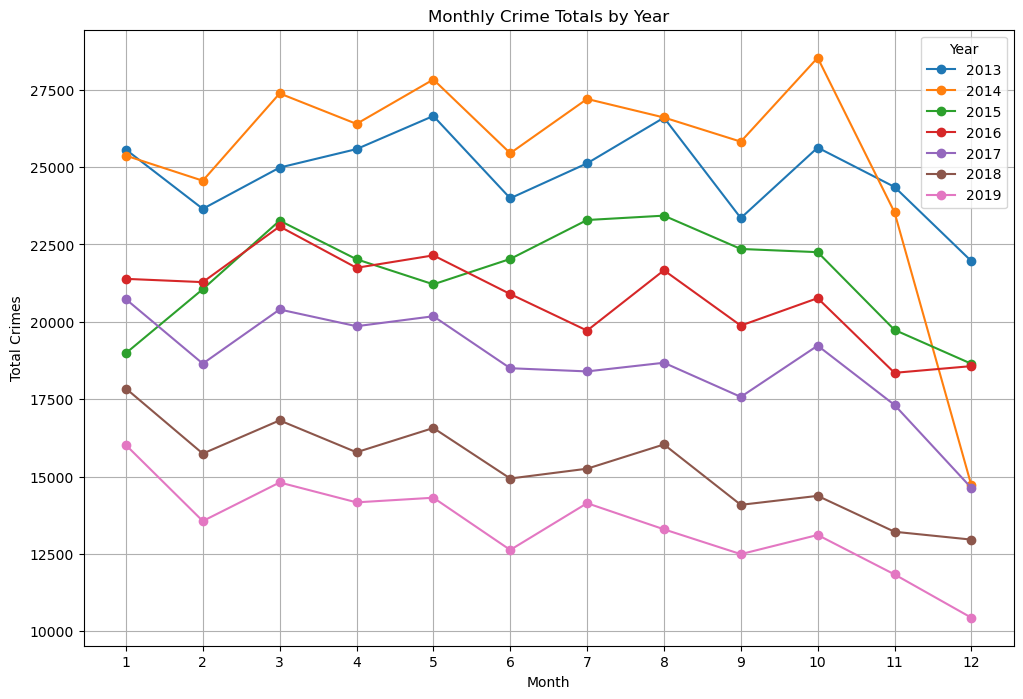

In [8]:
# Sum crimes by year and month
year_month_data = grouped_data.groupby(['arrest_year', 'arrest_month'])['total_crimes'].sum().unstack()

# Plot the data
plt.figure(figsize=(12, 8))
for year in year_month_data.index:
    plt.plot(
        year_month_data.columns,
        year_month_data.loc[year],
        marker='o',
        label=str(year)
    )

plt.title("Monthly Crime Totals by Year")
plt.xlabel("Month")
plt.ylabel("Total Crimes")
plt.xticks(range(1, 13))  # Ensure all months are displayed
plt.legend(title="Year", loc="upper right")
plt.grid(True)
plt.show()


In [9]:
grouped_data

,arrest_date,PRCP,SNOW,TMIN,TDELTA,arrest_year,arrest_month,arrest_day,total_crimes
0,2013-01-01,0.00,0.0,26,14,2013,1,1,676
1,2013-01-02,0.00,0.0,22,11,2013,1,2,880
2,2013-01-03,0.00,0.0,24,8,2013,1,3,1032
3,2013-01-04,0.00,0.0,30,7,2013,1,4,958
4,2013-01-05,0.00,0.0,32,10,2013,1,5,799
...,...,...,...,...,...,...,...,...,...
2551,2019-12-27,0.00,0.0,46,8,2019,12,27,349
2552,2019-12-28,0.00,0.0,43,8,2019,12,28,278
2553,2019-12-29,0.25,0.0,39,5,2019,12,29,226
2554,2019-12-30,0.74,0.0,37,4,2019,12,30,249


In [10]:
# Select weather-related variables and total crimes for the model
weather_data = grouped_data[['PRCP', 'SNOW', 'TMIN', 'TDELTA']]
total_crimes = grouped_data['total_crimes']

# Add a constant term for the intercept
weather_data = add_constant(weather_data)

# Fit the OLS model
ols_model = OLS(total_crimes, weather_data).fit()

# Display the summary of the model
ols_summary = ols_model.summary()
ols_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_crimes   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     17.03
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           8.66e-14
Time:                        19:45:21   Log-Likelihood:                -17300.
No. Observations:                2556   AIC:                         3.461e+04
Df Residuals:                    2551   BIC:                         3.464e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        604.3814     16.599     36.411      0.000     571.833     636.930
PRCP         -56.5715     12.048     -4.695      0.000     -80.196     -32.947
SNOW         -15.5250      5.047     -3.076      0.002     -25.421      -5.629
TMIN           0.3143      0.249      1.263      0.207      -0.173       0.802
TDELTA         3.2303      0.830      3.894      0.000       1.604       4.857
==============================================================================
Omnibus:                      120.224   Durbin-Watson:                   0.484
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.789
Skew:                           0.286   Prob(JB):                     5.75e-17
Kurtosis:                       2.388   Cond. No.                         215.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
# Select weather-related variables and total crimes for the model
weather_data = grouped_data[['PRCP', 'SNOW', 'TMIN', 'TDELTA']]
total_crimes = grouped_data['total_crimes']

# Add a constant term for the intercept
weather_data = add_constant(weather_data)

# Fit the OLS model
ols_model = OLS(total_crimes, weather_data).fit()

# Display the summary of the model
ols_summary = ols_model.summary()
print(ols_summary)

# Predictions
total_crimes_pred = ols_model.predict(weather_data)

                            OLS Regression Results                            
Dep. Variable:           total_crimes   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     17.03
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           8.66e-14
Time:                        19:45:21   Log-Likelihood:                -17300.
No. Observations:                2556   AIC:                         3.461e+04
Df Residuals:                    2551   BIC:                         3.464e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        604.3814     16.599     36.411      0.0

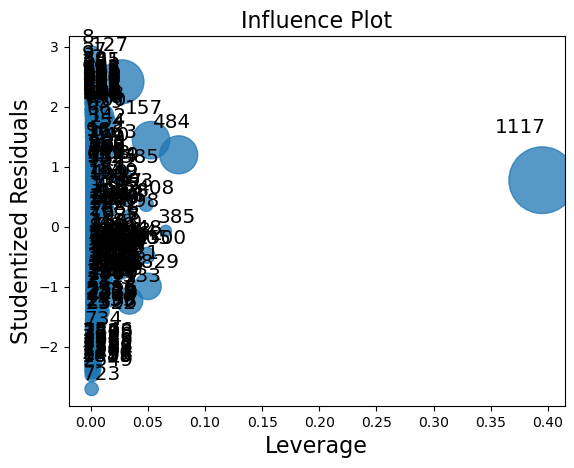

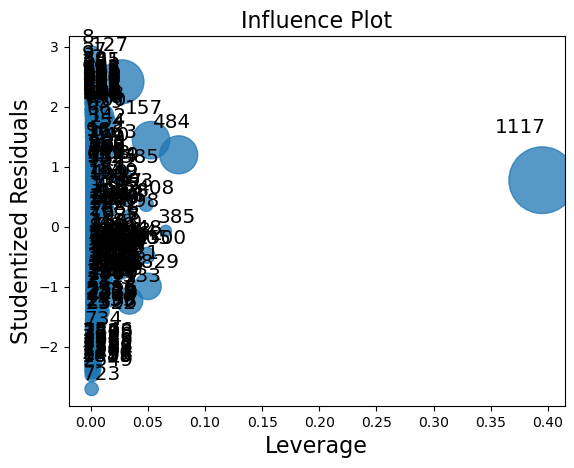

In [12]:
sm.graphics.influence_plot(ols_model, criterion="cooks")

In [13]:
influence = ols_model.get_influence()
cooks_d = influence.cooks_distance[0]

# Set a threshold for Cook's Distance
threshold = 4 / len(grouped_data)

# Identify outliers
outliers = np.where(cooks_d > threshold)[0]

In [14]:
outliers

array([   9,   30,   37,   57,   66,   98,  113,  127,  142,  157,  163,
        254,  400,  401,  407,  429,  435,  437,  442,  484,  485,  500,
        520,  528,  547,  548,  555,  638,  652,  653,  659,  695,  722,
        729,  734,  755,  762,  772,  808,  940,  982, 1117, 1118, 1139,
       1163, 1500, 1533, 1566, 1585, 1818, 1825, 1829, 1838, 1931, 2093,
       2151, 2175, 2184, 2190, 2210, 2211, 2288, 2315, 2322, 2336, 2490,
       2506, 2533, 2554])

In [15]:
df_no_outliers = grouped_data.drop(outliers)

X_no_outliers = df_no_outliers[['PRCP', 'SNOW', 'TMIN', 'TDELTA']]
X_no_outliers = sm.add_constant(X_no_outliers)
y_no_outliers = df_no_outliers['total_crimes']

model_no_outliers = sm.OLS(y_no_outliers, X_no_outliers).fit()

In [16]:
y_no_outliers_pred = model_no_outliers.predict(X_no_outliers)

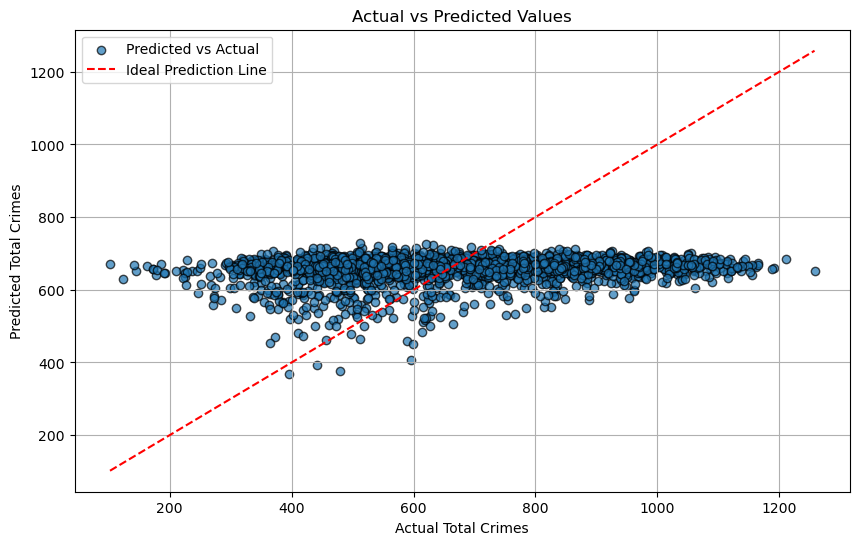

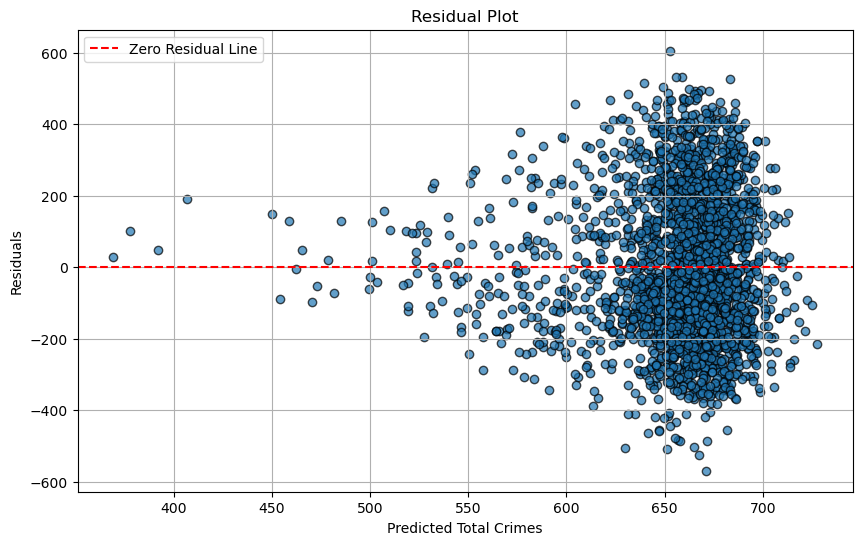

In [17]:
# 1. Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_no_outliers, y_no_outliers_pred, alpha=0.7, edgecolors='k', label='Predicted vs Actual')
plt.plot([min(total_crimes), max(total_crimes)], [min(total_crimes), max(total_crimes)],
         color='red', linestyle='--', label='Ideal Prediction Line')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Total Crimes')
plt.ylabel('Predicted Total Crimes')
plt.legend()
plt.grid(True)
plt.show()

# 2. Residual Plot
residuals = y_no_outliers - y_no_outliers_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_no_outliers_pred, residuals, alpha=0.7, edgecolors='k')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Predicted Total Crimes')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()